In [1]:
import timeit

import matplotlib.pyplot as plt
from jax import jit, grad, vmap
from jax import numpy as jnp
from jax.scipy.optimize import minimize
from jax import value_and_grad

#import scipy
#from scipy.integrate import solve_ivp
import numpy as np
from jax.scipy.linalg import expm
from scipy.signal import gaussian

from qiskit.quantum_info.operators import Operator
from qiskit_ode import dispatch, solve_lmde, solve_ode
from qiskit_ode.dispatch import Array
from qiskit_ode.models import HamiltonianModel
from qiskit_ode.signals import Constant, Signal, PiecewiseConstant

###############
# needed these:
from jax.config import config
config.update("jax_enable_x64", True)
dispatch.set_default_backend('jax')
###############

from qiskit_ode_internal.perturbation import solve_lmde_perturbation
from discrete_signals import get_param_to_signal
from objectives import get_grape_fidelity_func

Z = Array([[1., 0.], [0., -1.]], dtype=complex)
X = Array([[0., 1.], [1., 0.]], dtype=complex)
Y = Array([[0., -1j], [1j, 0.]], dtype=complex)

## Approximate fidelity curve with Magnus terms

In [2]:
#setting

dim = 2 # dimension cutoff for oscillators

# truncated annihilation, creation, and number operators
a = jnp.diag(np.sqrt(np.arange(1, dim, dtype=complex)), -1)
adag = a.conj().transpose()
numb = jnp.diag(np.arange(dim, dtype=complex))

# truncated oscillator X and Y
osc_X = a + adag
osc_Y = 1j*(a-adag)


# model parameters - work in units of GHz/ns
anharm = -0.33
drive_strength = 0.02

# drift Hamiltonian on resonance
H0 = Array(np.pi * anharm * numb * (numb - jnp.eye(dim)))
#H0 = np.zeros((dim,dim))

# control terms - X and Y multiplied by 2 pi * drive_strength
Hc = Array(2 * np.pi * drive_strength * jnp.array([osc_X, osc_Y]))
perturb = Array(-1j*2*np.pi*numb)

Utarget = X

Alist = -1j * Hc
D = -1j * H0

dt_filter = 0.125
T = 28.125

#get fidelity function
fid_func = get_grape_fidelity_func(X)

In [3]:
#use hardcoded signal with good robustness

#signal in the legendre basis
param = jnp.array([[-4.59237981e+00, 4.24980538e+01, -8.46739534e+01, 5.75898575e+01,-1.50812797e-01],
                  [5.81268528e+02, 1.81435728e+02, -5.81151908e+02, -6.48605967e+01,5.10149009e+02]])

In [4]:
#or, use hardcoded signal, randomly generated
#signal in the legendre basis
param = jnp.array([[0.42143394, 0.56289994, 0.18579787, 0.46135739, 0.00488543],
                  [0.37749316, 0.87822718, 0.18513398, 0.20995738, 0.47369254]])

In [5]:
#or, randomly generate your own signal
param = jnp.array(np.random.rand(2,5))

In [6]:
#convert the signal from legendre basis to time series

#get the filter
param_to_signal = get_param_to_signal(4, 25)
#get the signal
signal = param_to_signal(param)
signal1 = signal[:,0]
signal2 = signal[:,1]

In [7]:
pc1 = PiecewiseConstant(dt=dt_filter, samples=signal1,carrier_freq=0.)
pc2 = PiecewiseConstant(dt=dt_filter, samples=signal2,carrier_freq=0.)
operators = [H0, Hc[0], Hc[1]]
signals = [Constant(1.), pc1, pc2]
hamiltonian = HamiltonianModel(operators=operators, signals=signals)
hamiltonian.frame = hamiltonian.drift

def G(t):
    N_steps = jnp.linspace(0, dt_filter * 225, 225)
    c1 = pc1.value(t)
    c2 = pc2.value(t)
    return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

def A(t):#the perturbation
    return perturb

In [8]:
#use the "generator" as input
results = solve_lmde_perturbation(A_list=[A], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=5,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G, # generator
                             y0=np.eye(2), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=1e-13, # standard solver arguments
                             atol=1e-13)

In [9]:
#use the "hamiltonian" as input. Equivalent to using the "generator"
results = solve_lmde_perturbation(A_list=[A], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=5,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator = hamiltonian,
                             y0=np.eye(2), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=1e-13, # standard solver arguments
                             atol=1e-13)

In [10]:
U = results.y[-1]
M1 = results.perturbation_results[[0]][-1]
M2 = results.perturbation_results[[0, 0]][-1]
M3 = results.perturbation_results[[0, 0, 0]][-1]
M4 = results.perturbation_results[[0, 0, 0, 0]][-1]
M5 = results.perturbation_results[[0, 0, 0, 0, 0]][-1]

In [11]:
def err_est(detuning, order):
    if order == 1:       
        U_approx = U@expm(detuning*M1)  # 1st order
    elif order == 2:
        U_approx = U@expm(detuning*M1+detuning**2*M2)  # 2nd order
    elif order == 3:
        U_approx = U@expm(detuning*M1+detuning**2*M2+detuning**3*M3) #3rd order
    elif order == 4:
        U_approx = U@expm(detuning*M1+detuning**2*M2+detuning**3*M3+detuning**4*M4) #4th order
    elif order == 5:
        U_approx = U@expm(detuning*M1+detuning**2*M2+detuning**3*M3+detuning**4*M4+detuning**5*M5) #5th order
    fid = fid_func(U_approx)
    return 1. - fid 

In [53]:
z_vals = jnp.linspace(-1.5*drive_strength, 1.5*drive_strength, 201)

#error estimated using the Magnus terms
err_estimate1 = [err_est(z,1) for z in z_vals]
err_estimate2 = [err_est(z,2) for z in z_vals]
err_estimate3 = [err_est(z,3) for z in z_vals]
err_estimate4 = [err_est(z,4) for z in z_vals]
err_estimate5 = [err_est(z,5) for z in z_vals]

In [54]:
#exact error with the perturbation
operators1 = [H0, Hc[0], Hc[1], 1j*perturb]
hamiltonian1 = HamiltonianModel(operators=Array(operators1))
def exact_fid(detuning):
    signals1 = [Constant(1.), pc1, pc2, Constant(detuning)]
    ham_copy = hamiltonian1.copy()
    ham_copy.signals = signals1
    time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(2), atol=1e-13, rtol=1e-13,method='jax_odeint')
    return fid_func(time_results.y[-1]).data

fid_exact = vmap(exact_fid)(z_vals)

In [55]:
fid_func(U).data

DeviceArray(0.71834528, dtype=float64)

Text(0, 0.5, 'Error')

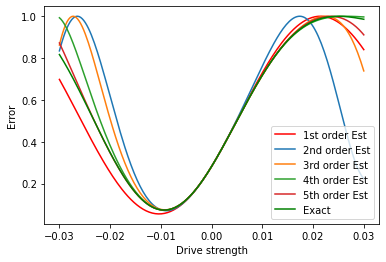

In [56]:
#plot the estimate and the exact errors together
plt.plot(z_vals, err_estimate1,color='r',label='1st order Est')
plt.plot(z_vals, err_estimate2,label='2nd order Est')
plt.plot(z_vals, err_estimate3,label='3rd order Est')
plt.plot(z_vals, err_estimate4,label='4th order Est')
plt.plot(z_vals, err_estimate5,label='5th order Est')
plt.plot(z_vals, 1-fid_exact,color='g',label='Exact')
plt.legend()
plt.xlabel('Drive strength')
plt.ylabel('Error')

### Compare the costs of objective functions that use an approximate fid curve and the exact fid curve

In [57]:
#random inputs
inputs = jnp.array(np.random.rand(10,2,5))

#objective function defined with the approximate fid curve (2nd order)
def obj1(param1):
    sig1 = param_to_signal(param1)
    pc1 = PiecewiseConstant(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2 = PiecewiseConstant(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)
    sigs = [Constant(1.), pc1, pc2]
    ham = HamiltonianModel(operators=operators, signals=sigs,validate=False)
    ham.frame = ham.drift
    results = solve_lmde_perturbation(A_list=[A], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=2,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator = ham,
                             y0=np.eye(2), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=1e-13, # standard solver arguments
                             atol=1e-13)
    U = results.y[-1]
    M1 = results.perturbation_results[[0]][-1]
    M2 = results.perturbation_results[[0, 0]][-1]
    def err(detuning):
        U_approx = U@expm(detuning*M1+detuning**2*M2)
        fid = Array(fid_func(U_approx)).data
        return 1. - fid
    err_estimate = vmap(err)(z_vals)
    n_samples = len(err_estimate)
    filter_Gaussian = jnp.array(gaussian(n_samples, n_samples/5))/n_samples
    return Array(jnp.sum(err_estimate*filter_Gaussian)).data

#objective function defined with the exact fid curve
def obj2(param2):
    sig2 = param_to_signal(param2)
    pc1 = PiecewiseConstant(dt=dt_filter, samples=sig2[:,0],carrier_freq=0.)
    pc2 = PiecewiseConstant(dt=dt_filter, samples=sig2[:,1],carrier_freq=0.)
    
    def err(detuning):
        signals_detuning = [Constant(1.), pc1, pc2, Constant(detuning)]
        ham_copy = hamiltonian1.copy()
        ham_copy.signals = signals_detuning
        time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(2), atol=1e-13, rtol=1e-13,method='jax_odeint')
        return 1 - Array(fid_func(time_results.y[-1])).data

    err_exact = vmap(err)(z_vals)
    n_samples = len(err_exact)
    filter_Gaussian = jnp.array(gaussian(n_samples, n_samples/5))/n_samples
    return Array(jnp.sum(err_exact*filter_Gaussian)).data

def f1():
    jit_obj = jit(value_and_grad(obj1))
    for i in range(len(inputs)):
        val, grad = jit_obj(inputs[i])

def f2():
    jit_obj = jit(value_and_grad(obj2))
    for i in range(len(inputs)):
        val, grad = jit_obj(inputs[i])

In [58]:
from time import time

In [59]:
jit_obj = jit(value_and_grad(obj1))

start = time()
val = jit_obj(inputs[0])[0].block_until_ready()
jit_time = time() - start

jitted_times = []
for rand_in in inputs[1:]:
    start = time()
    val = jit_obj(rand_in)[0].block_until_ready()
    jitted_times.append(time() - start)

print('Time to jit and run once: ' + str(jit_time))
print('Average jitted run time: ' + str(np.sum(jitted_times) / len(jitted_times)))
print('Average time including initial jit: ' + str((np.sum(jitted_times) + jit_time) / (len(jitted_times) + 1)))

Time to jit and run once: 12.565051794052124
Average jitted run time: 1.383296807607015
Average time including initial jit: 2.501472306251526


In [39]:
jit_obj = jit(value_and_grad(obj2))

start = time()
val = jit_obj(inputs[0])[0].block_until_ready()
jit_time = time() - start

jitted_times = []
for rand_in in inputs[1:]:
    start = time()
    val = jit_obj(rand_in)[0].block_until_ready()
    jitted_times.append(time() - start)

print('Time to jit and run once: ' + str(jit_time))
print('Average jitted run time: ' + str(np.sum(jitted_times) / len(jitted_times)))
print('Average time including initial jit: ' + str((np.sum(jitted_times) + jit_time) / (len(jitted_times) + 1)))

Time to jit and run once: 54.90186810493469
Average jitted run time: 44.60356460677253
Average time including initial jit: 45.633394956588745


In [29]:
jit_obj = jit_obj2 = jit(value_and_grad(obj1))

In [31]:
%time test = jit_obj(inputs[1])[0].block_until_ready()

CPU times: user 1.34 s, sys: 3.33 ms, total: 1.35 s
Wall time: 1.35 s


In [28]:
jit_obj2 = jit(value_and_grad(obj2))

In [25]:
%time test = jit_obj2(inputs[1])[0].block_until_ready()

CPU times: user 9.22 s, sys: 197 ms, total: 9.42 s
Wall time: 9.24 s


In [23]:
print(timeit.timeit(f2, number=1).block_until_ready())

AttributeError: 'float' object has no attribute 'block_until_ready'

In [ ]:
%timeit f1()